<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V2_1_COMPAS_Clustering_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

# UTILS (all)

## Sets of Features (aka data columns)

In [174]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female','race_African-American', 'race_Caucasian', 'race_Asian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled'] #, 'TP_scaled', 'TN_scaled', 'FN_scaled', 'FP_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']
DUMMY_COL_scaled_light = ['sex_Female_scaled', 'race_African-American_scaled', 'race_Caucasian_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']
SHAP_DUMMY_scaled_light = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled','Shap_race_Caucasian_scaled']

## Utils for Data Prep

In [175]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

In [176]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

## Utils for Clustering

In [177]:
# Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

In [178]:
def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
    if len(banned_clusters) != 0:
        filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
        all_cluster_ids = all_cluster_ids[filter_tf]

    print(f"Available cluster IDs for splitting: {all_cluster_ids}")

    for candidate_cluster_id in all_cluster_ids:
        if candidate_cluster_id == -1:
            continue

        candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
        print(f"Candidate cluster ID: {candidate_cluster_id}, size: {len(candidate_cluster)}")

        if len(candidate_cluster) < min_size:
            print(f"...Cluster ID {candidate_cluster_id} is too small.")
            continue
        else:
            return candidate_cluster_id

    print('No suitable clusters were found!')
    return -1

In [179]:
'''def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)'''

"def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):\n  if(len(banned_clusters) != 0):\n    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)\n    all_cluster_ids = all_cluster_ids[filter_tf]\n\n  for candidate_cluster_id in all_cluster_ids:\n    if candidate_cluster_id == -1:\n      continue\n\n    #print ('This is the next cluster:', candidate_cluster_id)\n\n    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]\n\n    if len(candidate_cluster) < min_size:\n      #print('...it is too small:', len(candidate_cluster))\n      continue\n    else:\n      return(candidate_cluster_id)\n\n  #print('No suitable clusters were found!')\n  return(-1)"

## Utils for Results

### Recap

In [180]:
def make_recap(data_result, feature_set):
  # MAKE RECAP of cluster info
  # ...with error rates
  res = data_result[['clusters', 'errors']]

  # ...with cluster size
  temp = data_result[['clusters']]
  temp['count'] = 1
  recap = temp.groupby(['clusters'], as_index=False).sum()

  # ...with number of error
  recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

  # ...with 1-vs-All error diff
  recap['error_rate'] = res.groupby(['clusters']).mean()
  # recap['std'] = (recap['error_rate'] * (1-recap['error_rate']))/recap['count']
  # recap['std'] = recap['std'].apply(np.sqrt)

  # Prepare Quality metrics
  diff_vs_rest = []
  # diff_std = []
  diff_p =[]

  race_aa_prop = []
  race_aa_diff = []
  race_aa_p = []

  race_c_prop = []
  race_c_diff = []
  race_c_p = []

  female_prop = []
  female_diff = []
  female_p = []

  silhouette = []

  # Get individual silhouette scores
  clusters = data_result['clusters']
  silhouette_val = silhouette_samples(data_result[feature_set], clusters)

  for c in recap['clusters']:
    # Get in-cluster data
    c_data = data_result.loc[data_result['clusters'] == c]
    c_count = recap['count'][c]

    # Get out-of-cluster data
    rest_data = data_result.loc[data_result['clusters'] != c]
    # Check if no other cluster
    if(len(rest_data) == 0):
      diff_vs_rest.append(np.nan)
      # diff_std.append(np.nan)
      diff_p.append(np.nan)

      race_aa_prop.append(np.nan)
      race_aa_diff.append(np.nan)
      race_aa_p.append(np.nan)

      race_c_prop.append(np.nan)
      race_c_diff.append(np.nan)
      race_c_p.append(np.nan)

      female_prop.append(np.nan)
      female_diff.append(np.nan)
      female_p.append(np.nan)
      break

    rest_recap = recap.loc[recap['clusters'] != c]
    rest_count = rest_recap['count'].sum()

    #### Quick test: differences in error rates
    # Get error rate difference 1-vs-rest
    rest_n_error = rest_recap['n_error'].sum()
    rest_rate = rest_n_error / rest_count
    diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

    # ...with std deviation of error differences
    # std_rest = (rest_rate * (1-rest_rate))/rest_count
    # std_rest = np.sqrt(std_rest)
    # diff_std.append(recap['std'][c] + std_rest)

    # ...with Poisson stat testprint('Zero!')
    # Deal with splits with 0 error (by using either number of errors (FN or FP), or number of correct classifications (TP or TN))
    if((recap['n_error'][c] < 1) | (recap['count'][c] < 1) | (rest_n_error < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c], rest_count - rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))

    ##### Sensitive features (gender, race) -- ['sex_Female', 'race_African-American', 'race_Caucasian']]
    ### Race African-American (AA)
    rest_n_aa = rest_data['race_African-American'].sum()
    rest_prop_aa = rest_n_aa / rest_count

    c_n_aa = c_data['race_African-American'].sum()
    c_prop_aa = c_n_aa / c_count

    race_aa_prop.append(c_prop_aa)
    race_aa_diff.append(c_prop_aa - rest_prop_aa)

    # Deal with splits with 0 African-American (by using either number of AA, or number of non-AA)
    if((c_n_aa < 1) | (c_count < 1) | (rest_n_aa < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_aa, c_count, rest_count - rest_n_aa, rest_count)
      race_aa_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_aa, c_count, rest_n_aa, rest_count)
      race_aa_p.append(round(res.pvalue, 3))

    ### Race Caucasian
    rest_n_c = rest_data['race_Caucasian'].sum()
    rest_prop_c = rest_n_c / rest_count

    c_n_c = c_data['race_Caucasian'].sum()
    c_prop_c = c_n_c / c_count

    race_c_prop.append(c_prop_c)
    race_c_diff.append(c_prop_c - rest_prop_c)

    # Deal with splits with 0 African-American (by using either number of AA, or number of non-AA)
    if((c_n_c < 1) | (c_count < 1) | (rest_n_c < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_c, c_count, rest_count - rest_n_c, rest_count)
      race_c_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_c, c_count, rest_n_c, rest_count)
      race_c_p.append(round(res.pvalue, 3))

    ##### Gender
    rest_n_female = rest_data['sex_Female'].sum()
    rest_prop_female = rest_n_female/ rest_count

    c_n_female = c_data['sex_Female'].sum()
    c_prop_female = c_n_female / c_count

    female_prop.append(c_prop_female)
    female_diff.append(c_prop_female - rest_prop_female)

    # Deal with splits with 0 females(by using either number of females, or number of males)
    if((c_n_female < 1) | (c_count < 1) | (rest_n_female < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_female, c_count, rest_count - rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_female, c_count, rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))

    # Add silhouette score
    silhouette.append(silhouette_val[clusters == c].mean())


  recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
  # recap['diff_std'] = np.around(diff_std, 3)
  recap['diff_p'] = diff_p

  recap['race_aa_prop'] = np.around(race_aa_prop, 3)
  recap['race_aa_diff'] = np.around(race_aa_diff, 3)
  recap['race_aa_p'] = race_aa_p

  recap['race_c_prop'] = np.around(race_c_prop, 3)
  recap['race_c_diff'] = np.around(race_c_diff, 3)
  recap['race_c_p'] = race_c_p

  recap['female_prop'] = np.around(female_prop, 3)
  recap['female_diff'] = np.around(female_diff, 3)
  recap['female_p'] = female_p

  recap['silhouette'] = silhouette

  recap['error_rate'] = np.around(recap['error_rate'] , 3)
  # recap['std'] = np.around(recap['std'] , 3)

  recap.rename(columns={'clusters':'c'}, inplace=True)
  #print(recap.sort_values(by=['diff_p']))

  return(recap)

### Chi-Square Tests

In [181]:
def make_chi_tests(results):
  chi_res = {'cond_descr': [],
            'cond_name': [],
            'error': [],
            'race_aa': [],
            'race_c': [],
            'gender': []}

  for i in range(0, len(results['cond_name'])):
    chi_res['cond_descr'].append(results['cond_descr'][i])
    chi_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    # Test error differences
    test_data = recap[['count', 'n_error']].copy(deep=True)

    test_data['count'] = test_data['count'] - test_data['n_error']
    test_data = test_data.rename(columns={"count": "n_correct"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['error'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test gender differences
    test_data = recap[['count', 'female_prop']].copy(deep=True)

    test_data['female_prop'] = round(test_data['count'] * test_data['female_prop'])
    test_data = test_data.rename(columns={"female_prop": "female_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['female_n']
    test_data = test_data.rename(columns={"count": "male_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['gender'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test Race AA differences
    test_data = recap[['count', 'race_aa_prop']].copy(deep=True)

    test_data['race_aa_prop'] = round(test_data['count'] * test_data['race_aa_prop'])
    test_data = test_data.rename(columns={"race_aa_prop": "race_aa_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['race_aa_n']
    test_data = test_data.rename(columns={"count": "race_not_aa_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['race_aa'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test Race Caucasian differences
    test_data = recap[['count', 'race_c_prop']].copy(deep=True)

    test_data['race_c_prop'] = round(test_data['count'] * test_data['race_c_prop'])
    test_data = test_data.rename(columns={"race_c_prop": "race_c_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['race_c_n']
    test_data = test_data.rename(columns={"count": "race_not_c_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['race_c'].append(test_res.pvalue)

    # print(test_data)
    # print(round(test_res.pvalue, 6))



  return(pd.DataFrame(chi_res))

### All Quality Metrics

In [182]:
def recap_quali_metrics(chi_res, results, exp_condition):
  all_quali = {'cond_descr': chi_res['cond_descr'],
            'cond_name': chi_res['cond_name'],
            'error': chi_res['error'],
            'race_aa': chi_res['race_aa'],
            'race_c': chi_res['race_c'],
            'gender': chi_res['gender'],
            'silhouette': []}

  for i in range(0, len(chi_res['cond_name'])):
    data = results['cond_res'][i]
    feature_set = exp_condition['feature_set'][i]
    clusters = data['clusters']
    silhouette_indiv = silhouette_samples(data[feature_set], clusters)
    silhouette_avg = silhouette_indiv.mean()
    all_quali['silhouette'].append(silhouette_avg)

  return(pd.DataFrame(all_quali))

## UTILS for Viz

In [183]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, size, tsne_columns):
  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, s=size,
                                hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.show()

# DBSCAN CLUSTERING

In [184]:
'''def hbac_dbscan(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = 0.03, #0.05 ,
                min_acceptable_cluster_prop = 0.03,
                min_acceptable_error_diff = 0.01,
                eps=10,
                min_samples= 42,
                max_iter=300):

    clus_model_kwargs = {'eps': eps, 'min_samples': min_samples}

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = dbscan.labels_

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data'''

"def hbac_dbscan(data, columns_to_use=[], error='errors',\n                min_splittable_cluster_prop = 0.03, #0.05 ,\n                min_acceptable_cluster_prop = 0.03,\n                min_acceptable_error_diff = 0.01,\n                eps=10,\n                min_samples= 42,\n                max_iter=300):\n\n    clus_model_kwargs = {'eps': eps, 'min_samples': min_samples}\n\n    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split\n    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split\n\n    # Initialize loop's variables\n    data['clusters'] = 0\n    banned_clusters = []\n\n    #### CLUSTERING LOOP\n    for i in range(1, max_iter):\n      # Init temporary cluster\n      data['new_clusters'] = None\n\n      ### Select the cluster to split in 2\n      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(

In [185]:
def hbac_dbscan(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop=0.03,
                min_acceptable_cluster_prop=0.03,
                min_acceptable_error_diff=0.01,
                eps=10,
                max_iter=300):

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))
    min_samples = min_splittable_cluster_size  # Set min_samples to min_splittable_cluster_size

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
        # Init temporary cluster
        data['new_clusters'] = None

        ### Select the cluster to split in 2
        x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
        if x == -1:
            break

        candidate_cluster = data.copy(deep=True)
        candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

        #### SPLIT IN 2 SUB-CLUSTERS
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(candidate_cluster[columns_to_use])
        candidate_cluster['new_clusters'] = dbscan.labels_

        unique_new_clusters = candidate_cluster['new_clusters'].unique()
        print(f"DBSCAN identified new clusters: {unique_new_clusters}")

        # Filter out noise
        candidate_cluster = candidate_cluster[candidate_cluster['new_clusters'] != -1]
        unique_new_clusters = candidate_cluster['new_clusters'].unique()

        # Check all unique clusters
        if len(unique_new_clusters) <= 1:
            banned_clusters.append(x)
            continue

        # Check sub-cluster sizes and error rates
        valid_split = True
        error_rates = []
        for new_cluster in unique_new_clusters:
            sub_cluster = candidate_cluster[candidate_cluster['new_clusters'] == new_cluster]
            if len(sub_cluster) < min_acceptable_cluster_size:
                print(f"Sub-cluster {new_cluster} is too small, size: {len(sub_cluster)}")
                banned_clusters.append(x)
                valid_split = False
                break
            error_rate = get_error_rate(sub_cluster, column=error)
            print(f"Error rate for sub-cluster {new_cluster}: {error_rate}")
            error_rates.append(error_rate)

        if not valid_split:
            continue

        if abs(max(error_rates) - min(error_rates)) < min_acceptable_error_diff:
            print(f"Error rate difference is too small.")
            banned_clusters.append(x)
            continue

        ### Re-integrate to main data
        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

        # Make new Cluster IDs
        new_id = data['clusters'].unique().max() + 1
        for new_cluster in unique_new_clusters:
            data.loc[(data['clusters'] == x) & (candidate_cluster['new_clusters'] == new_cluster), 'clusters'] = new_id

        print(f"New cluster IDs assigned from split of cluster {x}")

    return data


# RUN EXPERIMENTS

### Prepare Data

In [186]:
data_shaper = pd.read_csv('https://raw.githubusercontent.com/MDankloff/ClusterCompas/main/Compas_error_shap.csv')

In [187]:
# Split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(data_shaper)
TNFP_data = subset_TN_FP(data_shaper)

In [198]:
# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()

In [199]:
round(0.03 * len(TNFP_data))

0

### Set experimental conditions

In [200]:
##### Make and name the sets of features to experiment with
feature_set_name = []
feature_set_descr = []
feature_set = []

### Does adding SHAP help the clustering?
# Baseline (Mitzal-Radheka)
feature_set_name.append('+REG +SENS -ERR -SHAP')
feature_set_descr.append('Baseline')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light)

# Baseline with Error (Selma)
feature_set_name.append('+REG +SENS +ERR -SHAP')
feature_set_descr.append('Baseline with Error')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light + ERROR_COL_scaled)

# Adding SHAP values to Baseline (Mirthe;)
feature_set_name.append('+REG +SENS -ERR +SHAP')
feature_set_descr.append('Baseline with SHAP')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light)

feature_set_name.append('+REG +SENS +ERR +SHAP')
feature_set_descr.append('Baseline with SHAP & Error')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light + ERROR_COL_scaled)


### Does SHAP alone allow to identify clusters?
# Using only SHAP values
feature_set_name.append('-REG -SENS -ERR +SHAP')
feature_set_descr.append('SHAP only')
feature_set.append(SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light)

feature_set_name.append('-REG -SENS +ERR +SHAP')
feature_set_descr.append('SHAP only with Error')
feature_set.append(SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light + ERROR_COL_scaled)


### Do sensitive features alone allow to identify clusters?
# Using only Sensitive features
feature_set_name.append('-REG +SENS -ERR -SHAP')
feature_set_descr.append('Sensitive features only')
feature_set.append(DUMMY_COL_scaled_light)

feature_set_name.append('-REG +SENS +ERR -SHAP')
feature_set_descr.append('Sensitive features with Error')
feature_set.append(DUMMY_COL_scaled_light + ERROR_COL_scaled)

### Does adding SHAP help the clustering based on sensitive features?
# Using Sensitive features with SHAP values
feature_set_name.append('-REG +SENS -ERR +SHAP')
feature_set_descr.append('Sensitive features with SHAP')
feature_set.append(DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light)

feature_set_name.append('-REG +SENS +ERR +SHAP')
feature_set_descr.append('Sensitive features with SHAP & Error')
feature_set.append(DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light + ERROR_COL_scaled)

In [201]:
exp_condition = pd.DataFrame({'feature_set_descr': feature_set_descr,
                              'feature_set_name': feature_set_name,
                              'feature_set': feature_set})
exp_condition

,feature_set_descr,feature_set_name,feature_set
0,Baseline,+REG +SENS -ERR -SHAP,"[age_scaled, decile_score_scaled, priors_count..."
1,Baseline with Error,+REG +SENS +ERR -SHAP,"[age_scaled, decile_score_scaled, priors_count..."
2,Baseline with SHAP,+REG +SENS -ERR +SHAP,"[age_scaled, decile_score_scaled, priors_count..."
3,Baseline with SHAP & Error,+REG +SENS +ERR +SHAP,"[age_scaled, decile_score_scaled, priors_count..."
4,SHAP only,-REG -SENS -ERR +SHAP,"[Shap_age_scaled, Shap_decile_score_scaled, Sh..."
5,SHAP only with Error,-REG -SENS +ERR +SHAP,"[Shap_age_scaled, Shap_decile_score_scaled, Sh..."
6,Sensitive features only,-REG +SENS -ERR -SHAP,"[sex_Female_scaled, race_African-American_scal..."
7,Sensitive features with Error,-REG +SENS +ERR -SHAP,"[sex_Female_scaled, race_African-American_scal..."
8,Sensitive features with SHAP,-REG +SENS -ERR +SHAP,"[sex_Female_scaled, race_African-American_scal..."
9,Sensitive features with SHAP & Error,-REG +SENS +ERR +SHAP,"[sex_Female_scaled, race_African-American_scal..."


### Execute experiments

In [205]:
TNFP_data.columns

Index(['age', 'decile_score', 'priors_count', 'sex_Female',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'age_scaled',
       'decile_score_scaled', 'priors_count_scaled', 'sex_Female_scaled',
       'race_African-American_scaled', 'race_Asian_scaled',
       'race_Caucasian_scaled', 'race_Hispanic_scaled',
       'race_Native American_scaled', 'race_Other_scaled', 'errors', 'TP',
       'TN', 'FN', 'FP', 'Error_Type', 'Shap_age', 'Shap_decile_score',
       'Shap_priors_count', 'Shap_sex_Female', 'Shap_race_African-American',
       'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
       'Shap_race_Native American', 'Shap_race_Other', 'Shap_age_scaled',
       'Shap_decile_score_scaled', 'Shap_priors_count_scaled',
       'Shap_sex_Female_scaled', 'Shap_race_African-American_scaled',
       'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled',
       'Shap_race_Hispanic_scaled', 'Shap_rac

In [204]:
features_to_include = [col for col in TNFP_data.columns if col != 'Error_Type']
nn_features = TNFP_data[features_to_include]

# Check if nn_features is empty and investigate why if it is.
if nn_features.empty:
    print("Warning: nn_features DataFrame is empty. Check your filtering logic.")
    # Add debugging code here to inspect TNFP_data and features_to_include

minPts = 50  # Example value, calculated as 2 * dim
k = minPts - 1

neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(nn_features)
distances, indices = neigh.kneighbors(nn_features)

# Sort the distances to the k-th nearest neighbor
distances = np.sort(distances[:, -1], axis=0)

# Plot the k-distance
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel(f'{k}-distance')
plt.title('K-Distance Plot')
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 52)) while a minimum of 1 is required by NearestNeighbors.

In [ ]:
##### HBAC parameters
min_splittable_cluster_prop = 0.05
min_acceptable_cluster_prop = 0.05
min_acceptable_error_diff = 0.005

In [203]:
res = hbac_dbscan(TNFP_data, columns_to_use=exp_condition['feature_set'][0], error='errors', eps=0.01, max_iter=300)
num_clusters = res['clusters'].nunique()
print(f"{num_clusters} cluster(s) found for feature set 1.")

Available cluster IDs for splitting: []
No suitable clusters were found!
0 cluster(s) found for feature set 1.


In [ ]:
from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}

for i in range(0, len(exp_condition)):
  res = hbac_dbscan(TNFP_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  error='errors',
                  min_splittable_cluster_prop = 0.05, #min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = 0.05, #min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  eps=10,
                  min_samples=50,
                  max_iter=100)

  # Check if res is empty
  if res is None:
    print(f"Warning: hbac_dbscan returned None for feature set {i}. Skipping.")
    continue  # Move to the next iteration

  # Check the number of unique clusters
  num_clusters = len(res['clusters'].unique())
  if num_clusters <= 1:
    print(f"Warning: Only {num_clusters} cluster(s) found for feature set {i}. Skipping silhouette calculation.")
    recap = None  # Or handle this case appropriately
  else:
    recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

In [ ]:
res = hbac_dbscan(TNFP_data, columns_to_use = exp_condition['feature_set'][0], error ='errors', eps=0.1, min_samples=5, max_iter=300)
print(f"{num_clusters} cluster(s) found for feature set {1}.")

In [ ]:
res = hbac_dbscan(TNFP_data, columns_to_use = exp_condition['feature_set'][0], error ='errors', eps=0.8, min_samples=2, max_iter=100)
print(f"{num_clusters} cluster(s) found for feature set {1}.")

In [ ]:
# Define a range of eps values to experiment with
eps_values = [0.1, 0.001, 0.0001, 0.00001, 10, 20, 30, 100, 150]

# Loop over different eps values
for eps in eps_values:
    print(f"Running experiments with eps = {eps}")
    results = {'cond_name': [],
               'cond_descr': [],
               'cond_res': [],
               'cond_recap': []}

    for i in range(len(exp_condition)):
        res = hbac_dbscan(TNFP_data.copy(deep=True),
                          columns_to_use=exp_condition['feature_set'][i],
                          error='errors',
                          min_splittable_cluster_prop=min_splittable_cluster_prop,
                          min_acceptable_cluster_prop=min_acceptable_cluster_prop,
                          min_acceptable_error_diff=min_acceptable_error_diff,
                          eps=eps,
                          min_samples=2,
                          max_iter=100)

        num_clusters = len(res['clusters'].unique())
        if num_clusters <= 1:
            print(f"Warning: Only {num_clusters} cluster(s) found for feature set {i}. Skipping silhouette calculation.")
            recap = None
        else:
            recap = make_recap(res, exp_condition['feature_set'][i])

        results['cond_name'].append(exp_condition['feature_set_name'][i])
        results['cond_descr'].append(exp_condition['feature_set_descr'][i])
        results['cond_res'].append(res)
        results['cond_recap'].append(recap)


In [ ]:
for feature in exp_condition['feature_set'][0]:  # Replace 0 with the index of the feature set you want to visualize
    plt.hist(TNFP_data[feature])
    plt.title(feature)
    plt.show()

# ANALYZE RESULTS


### t-SNE TNFP data

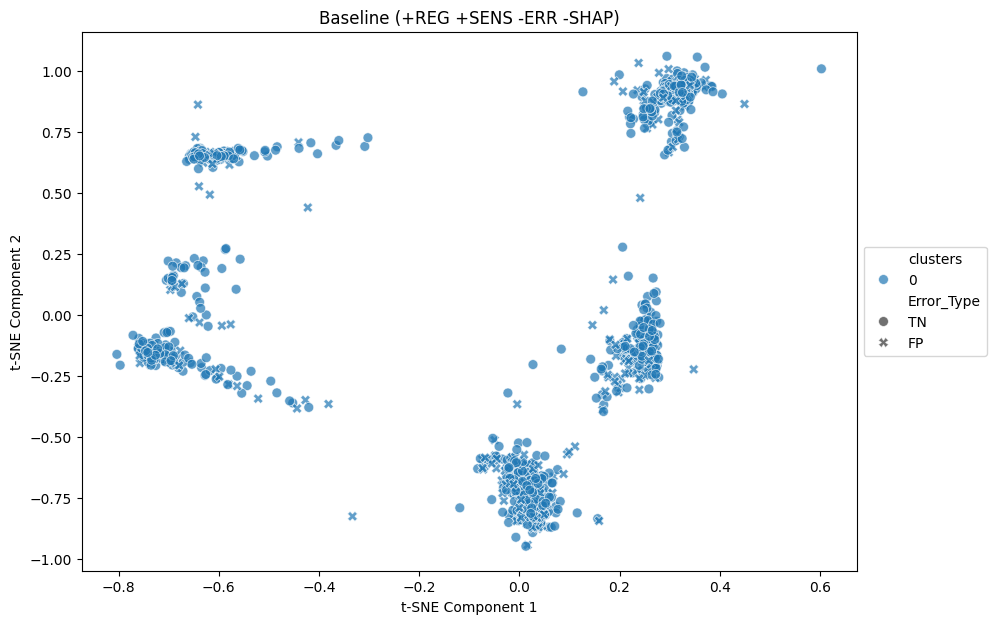

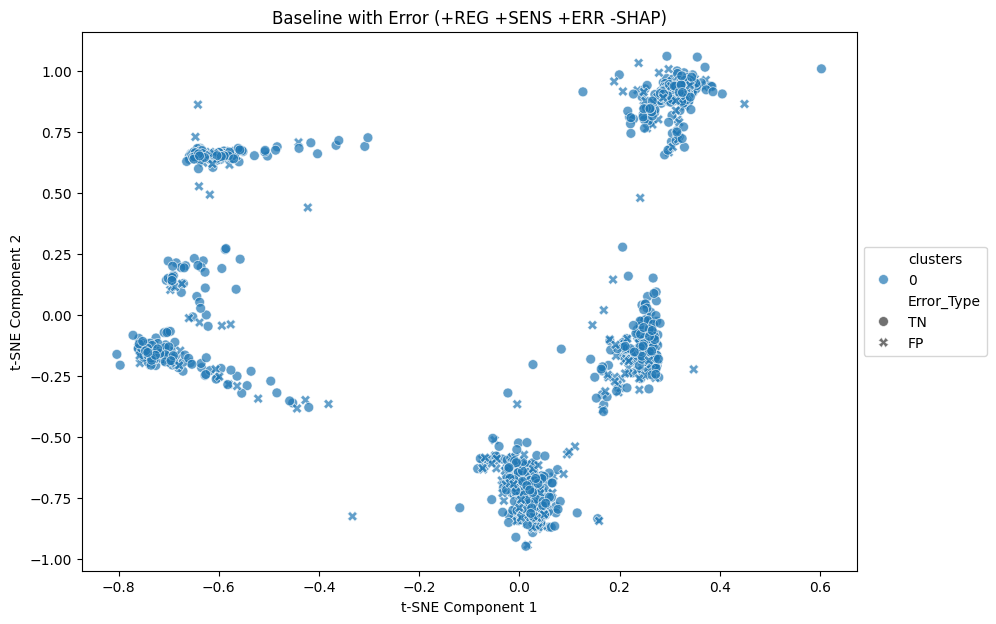

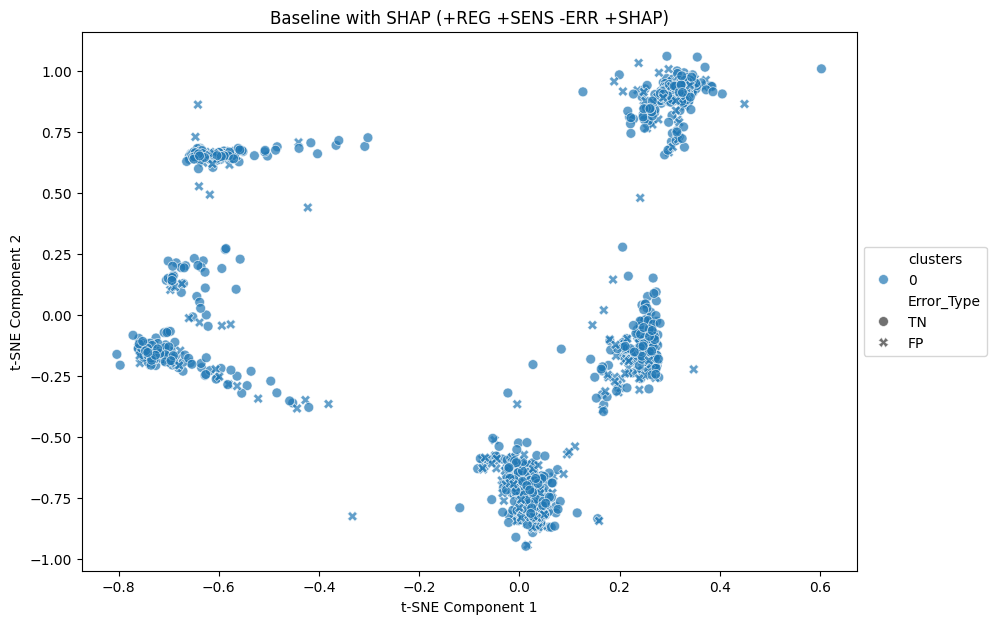

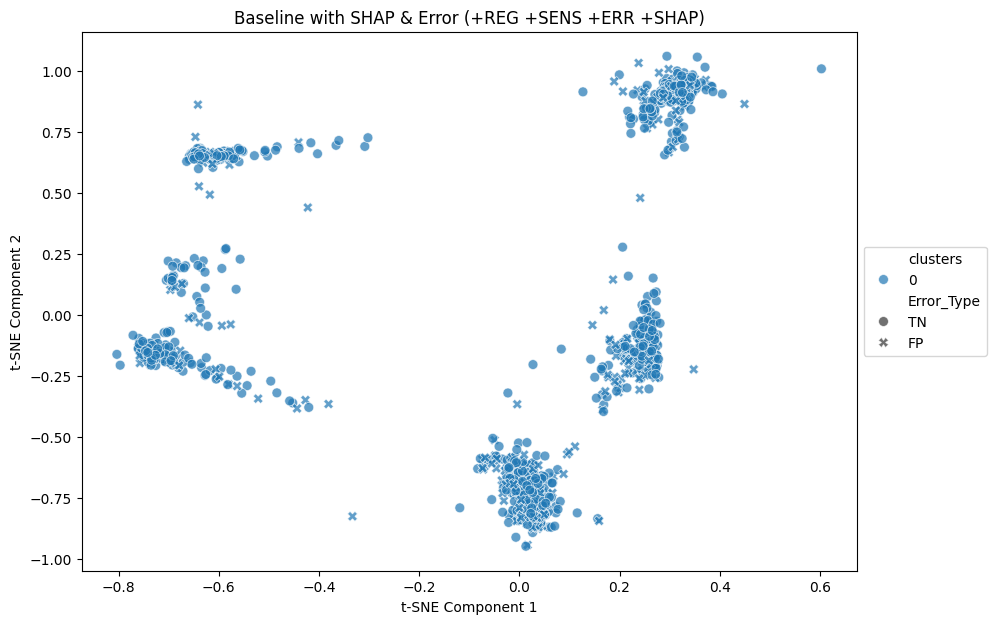

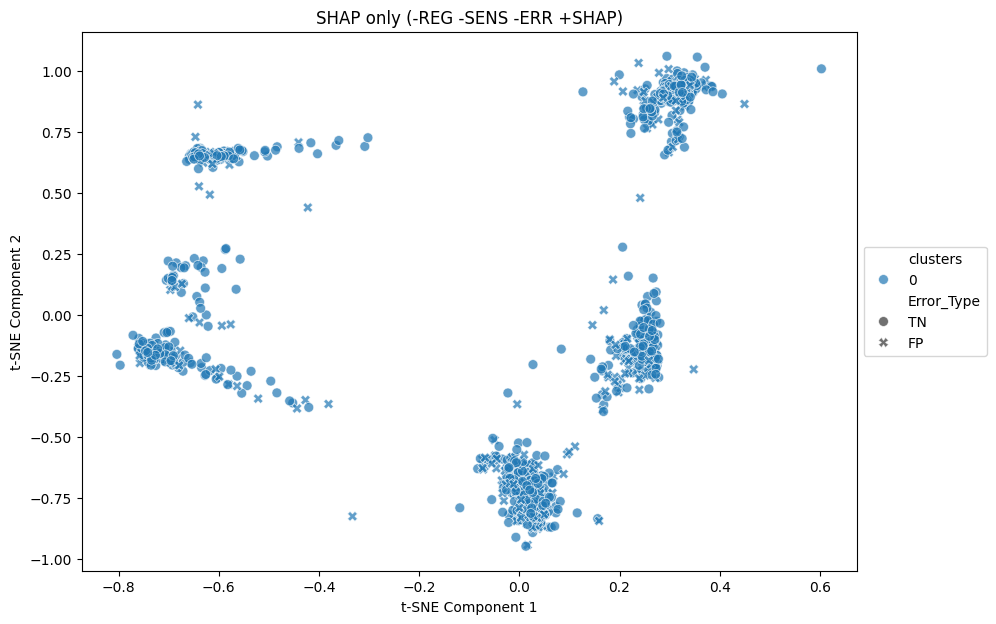

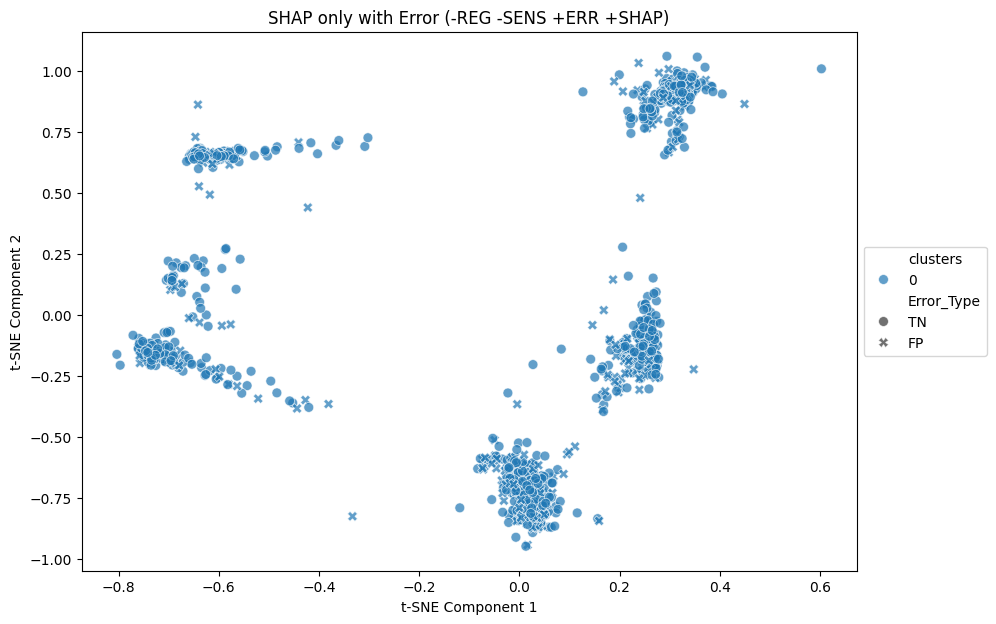

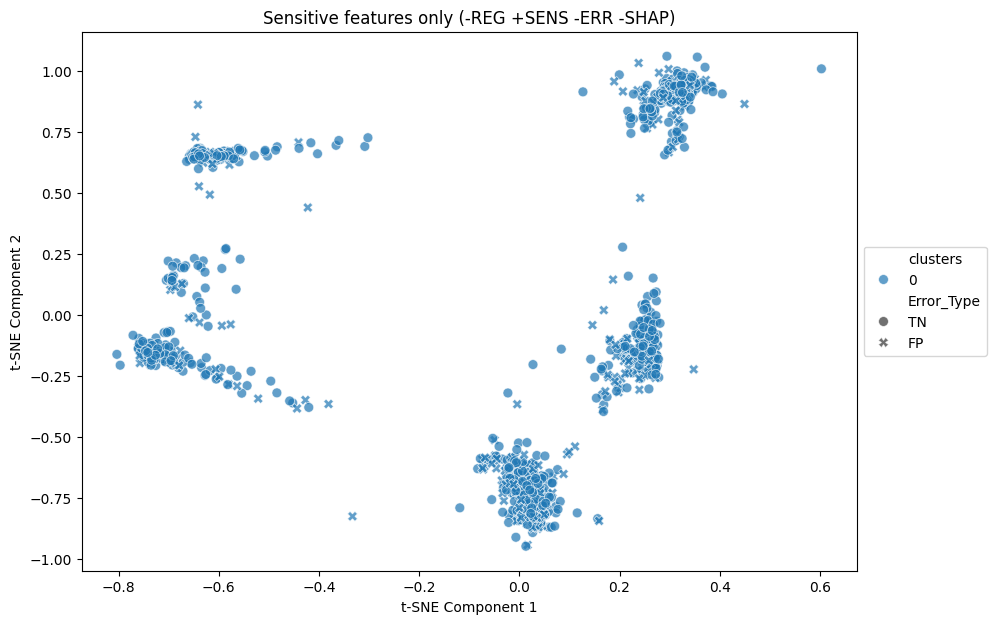

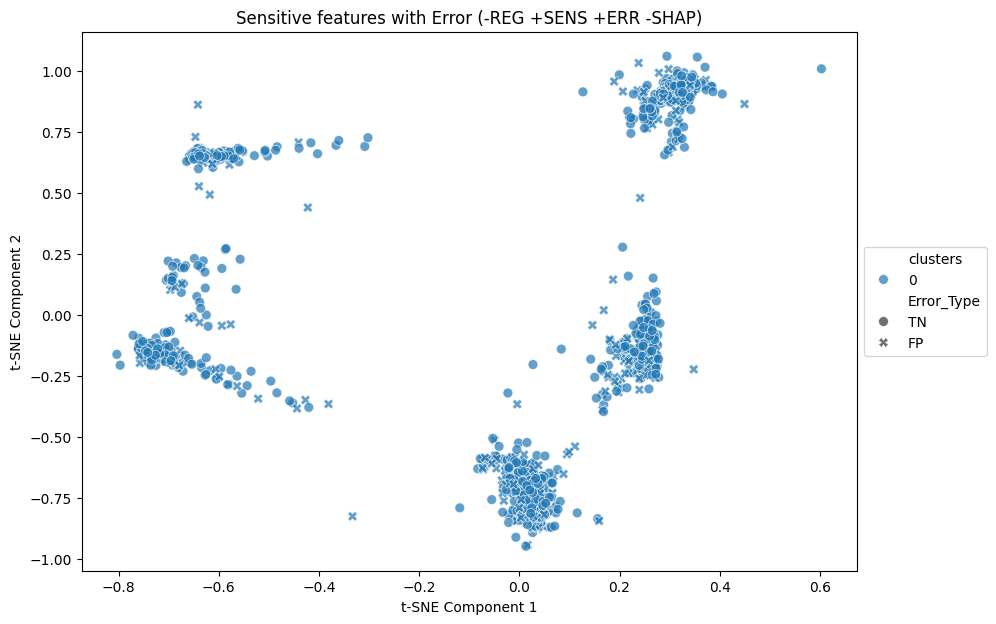

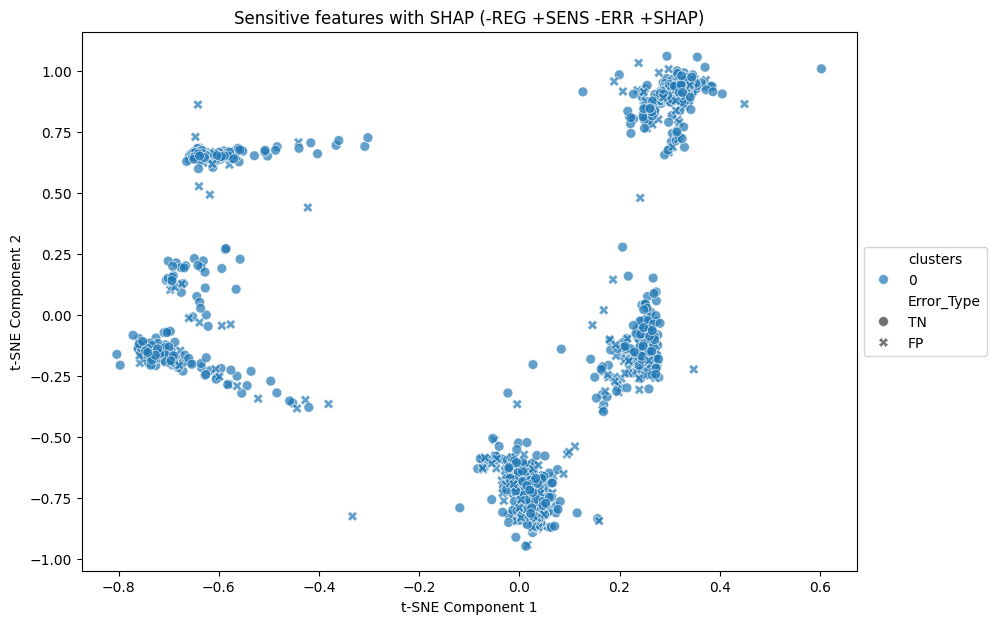

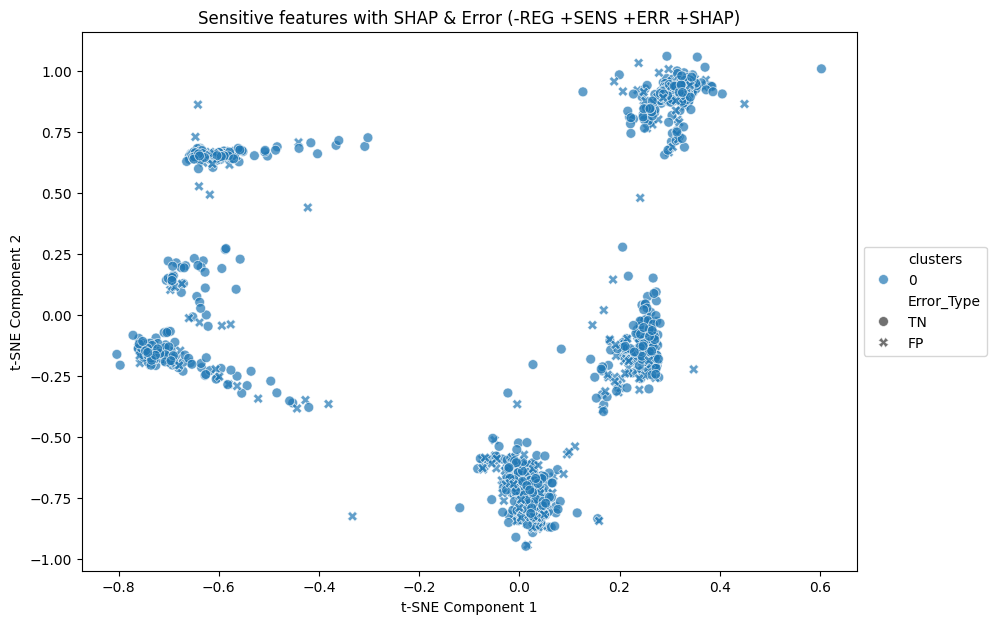

In [157]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = results['cond_descr'][i] + ' (' + results['cond_name'][i] + ')',
                      alpha = 0.7, size = 50,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

### One-vs-All cluster comparison TNFP data

In [158]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(20,6))
  ax = sns.heatmap(recap, annot=True, center=0,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(results['cond_descr'][i] + ' (' +results['cond_name'][i] + ')')
  ax.xaxis.tick_top()
  plt.yticks(rotation='horizontal')
  plt.show()

0


AttributeError: 'NoneType' object has no attribute 'sort_values'

### Chi-Square Tests TNFP data

In [ ]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### All Quality Metrics TNFP data

In [ ]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
# all_quali

In [ ]:
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(all_quali_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### t-SNE TPFN data

In [ ]:
##### HBAC parameters
min_splittable_cluster_prop = 0.05
min_acceptable_cluster_prop = 0.05
min_acceptable_error_diff = 0.005

results2 = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}

for i in range(0, len(exp_condition)):
  res = hbac_kmeans(TPFN_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results2['cond_name'].append(exp_condition['feature_set_name'][i])
  results2['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results2['cond_res'].append(res)
  results2['cond_recap'].append(recap)

In [ ]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results2['cond_res'][i], title = results2['cond_descr'][i] + ' (' + results2['cond_name'][i] + ')',
                      alpha = 0.7, size = 50,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

## One-vs-All cluster comparison TPFN data

In [ ]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results2['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(20,6))
  ax = sns.heatmap(recap, annot=True, center=0,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(results['cond_descr'][i] + ' (' +results['cond_name'][i] + ')')
  ax.xaxis.tick_top()
  plt.yticks(rotation='horizontal')
  plt.show()

##Chi-Square Tests TPFN data

In [ ]:
chi_res2 = make_chi_tests(results2)
chi_res_viz2 = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz2 = round(chi_res_viz2, 6)
chi_res_viz2

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz2, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

## All Quality Metrics TPFN data

In [ ]:
all_quali2 = recap_quali_metrics(chi_res, results2, exp_condition)
# all_quali2
all_quali_viz2 = all_quali2.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz2 = round(all_quali_viz2, 6)
# all_quali_viz2

plt.figure(figsize=(10,6))
ax = sns.heatmap(all_quali_viz2, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()